In [6]:
import pandas as pd 
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_colwidth = 1000

In [23]:
t = pd.read_csv('./data/train.csv')

In [34]:
t['country'] = t.city.str.extract(r', (.+)')

In [35]:
t['country'] = t['country'].str.lower()

In [36]:
t['cd'] = t['country'].map(country2code)

In [37]:
t['cd'].isna().sum()

2137762

In [41]:
2137762/15932992

0.13417203749302078

In [43]:
t.loc[t.cd.isna(), ['country', 'city', 'platform', 'cd']].country.unique()

array(['usa', 'south korea', 'russia', 'serbia', 'taiwan', 'crimea',
       'china', 'vietnam', 'iran', 'curacao', 'us virgin islands',
       'montenegro', 'french antilles', 'laos', 'east timor', 'syria',
       'vatican city', 'tanzania', 'palestinian territories',
       'sint maarten', 'republic of macedonia', 'moldova',
       'democratic republic of congo', 'são tomé and príncipe', 'zambia',
       'bes islands', 'kosovo', 'lesser antilles', 'the gambia',
       'bermudas', 'ivory coast', 'brunei', 'libya', 'guinea-bissau',
       'gerwen, netherlands', 'republic of south sudan'], dtype=object)

In [44]:
country2code['russia']

KeyError: 'russia'

In [47]:
np.save('./data/country2code.npy', country2code)

In [48]:
np.save('./data/code2country.npy', code2country)

In [30]:
t.shape

(15932992, 14)

In [38]:
t.country.iloc[0]

'australia'

In [32]:
country2code['australia']

'au'

In [40]:
'AU'  in t.platform.unique()

True

In [57]:
t.iloc[:1000].city.str.extract(r', (.+)').iloc[0].values

array(['Australia'], dtype=object)

In [14]:
t[t.action_type=='change of sort order'].current_filters.value_counts()

Sort by Price    1
Best Value       1
Name: current_filters, dtype: int64

In [3]:
train_basic = pd.read_parquet('./gbm_cache_prev/basic_preprocessed_train_None.snappy')

In [4]:
train_basic.action_type.unique()

array(['clickout item', 'search for item', 'filter selection',
       'interaction item image', 'change of sort order',
       'interaction item deals', 'search for destination',
       'search for poi', 'interaction item info',
       'interaction item rating'], dtype=object)

In [10]:
train_basic[train_basic.action_type=='change of sort order'].current_filters.value_counts()

Best Value    1
Name: current_filters, dtype: int64

In [17]:
# train_basic[train_basic.action_type=='change of sort order']
sids = train_basic.iloc[:10000].groupby('session_id').apply(lambda df: (df.action_type == 'change of sort order').sum()!=0)

In [18]:
sid = sids[sids].index

In [27]:
train_basic[train_basic.session_id==np.random.choice(sid, 1)[0]]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
9509,IUQAAOAOXG66,006cb1becbd7e,1.541357e+09,1.0,search for poi,Praia do Brejatuba,BR,"Guaratuba, Brazil",mobile,None,None,None
9510,IUQAAOAOXG66,006cb1becbd7e,1.541357e+09,2.0,search for destination,"Guaratuba, Brazil",BR,"Guaratuba, Brazil",mobile,None,None,None
9511,IUQAAOAOXG66,006cb1becbd7e,1.541357e+09,3.0,change of sort order,interaction sort button,BR,"Guaratuba, Brazil",mobile,None,None,None
9512,IUQAAOAOXG66,006cb1becbd7e,1.541357e+09,4.0,change of sort order,price and recommended,BR,"Guaratuba, Brazil",mobile,None,None,None
9513,IUQAAOAOXG66,006cb1becbd7e,1.541357e+09,5.0,filter selection,Best Value,BR,"Guaratuba, Brazil",mobile,Best Value,None,None
9514,IUQAAOAOXG66,006cb1becbd7e,1.541358e+09,6.0,change of sort order,interaction sort button,BR,"Guaratuba, Brazil",mobile,None,None,None
9515,IUQAAOAOXG66,006cb1becbd7e,1.541358e+09,7.0,change of sort order,rating only,BR,"Guaratuba, Brazil",mobile,None,None,None
9516,IUQAAOAOXG66,006cb1becbd7e,1.541358e+09,8.0,filter selection,Sort By Rating,BR,"Guaratuba, Brazil",mobile,Sort By Rating,None,None
9517,IUQAAOAOXG66,006cb1becbd7e,1.541358e+09,10.0,interaction item image,3244133,BR,"Guaratuba, Brazil",mobile,None,None,None
9518,IUQAAOAOXG66,006cb1becbd7e,1.541358e+09,17.0,interaction item image,3244133,BR,"Guaratuba, Brazil",mobile,None,None,None


In [23]:
train_basic[train_basic.action_type=='filter selection']['reference'].value_counts()

Sort by Price                      76266
Hotel                              52526
Best Value                         42472
5 Star                             40682
4 Star                             38116
Resort                             37886
Hostal (ES)                        31443
Focus on Distance                  30781
Motel                              30078
3 Star                             21954
Free WiFi (Combined)               19429
Very Good Rating                   18517
Breakfast Included                 18507
House / Apartment                  16988
Excellent Rating                   16825
Car Park                           13966
Swimming Pool (Combined Filter)    13748
Sort By Distance                   11614
Good Rating                        11539
Serviced Apartment                 10646
Focus on Rating                     9003
Air Conditioning                    7455
Spa (Wellness Facility)             7272
Sort By Rating                      6410
2 Star          

In [1]:
action_type2natural = {'clickout item': 0,
                       'search for poi': 1,
                       'search for destination': 1,
                       'search for item': 2,
                       'interaction item image': 2,
                       'interaction item info': 2,
                       'interaction item deals': 2,
                       'interaction item rating': 2,
                       'filter selection': 3,
                       'change of sort order': 4}

In [17]:
a = a.split('\n')

In [21]:
country_code = {i.split('-')[0].strip().lower(): i.split('-')[1].strip().lower() for i in a}

In [27]:
code2country = country_code
country2code = {v: k for k, v in code2country.items()}

In [5]:
len(set(action_type2natural.values()))

5

In [28]:
train_basic[train_basic.action_type=='change of sort order']['reference'].value_counts()

interaction sort button     204547
price only                   76209
price and recommended        42467
distance only                11605
distance and recommended      9456
rating and recommended        9004
rating only                   6410
our recommendations           3342
Name: reference, dtype: int64

In [33]:
search_item_sids = train_basic.iloc[:10000].groupby('session_id').apply(lambda df: (df.action_type == 'search for item').sum()!=0)

In [42]:
train_basic[train_basic.session_id==np.random.choice(search_item_sids[search_item_sids].index, 1)[0]]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
5224,1C3J2D18L0OT,00388681f4c0a,1.541202e+09,1.0,search for item,1299897,BR,"Balneário Camboriú, Brazil",desktop,None,None,None
5225,1C3J2D18L0OT,00388681f4c0a,1.541202e+09,2.0,clickout item,1299897,BR,"Balneário Camboriú, Brazil",desktop,None,1299897|1266075|2096198|2454104|3842488|3805414|5640586|6689428|9356860|3977594|2248496|2640170|5476434|4084462|2344190|3166072|4103288|1827413|965967|1652507|1348600|5952238|1814243|1947653|4838730,70|62|39|56|39|32|38|45|24|43|2775|29|28|44|80|38|34|74|45|48|65|48|49|44|32
5226,1C3J2D18L0OT,00388681f4c0a,1.541202e+09,3.0,search for item,588596,BR,"Balneário Camboriú, Brazil",desktop,None,None,None
5227,1C3J2D18L0OT,00388681f4c0a,1.541202e+09,4.0,clickout item,588596,BR,"Balneário Camboriú, Brazil",desktop,None,588596|588441|1348600|1240766|585331|3805414|5640586|6689428|9356860|586771|3977594|2096198|2640170|5476434|4084462|3166072|4103288|965967|1652507|5952238|1814243|1947653|2454104|4838730|1244892,101|70|65|107|113|32|38|45|24|99|43|39|29|28|44|38|34|45|48|48|49|44|56|32|88
5228,1C3J2D18L0OT,00388681f4c0a,1.541202e+09,5.0,search for item,512136,BR,"Balneário Camboriú, Brazil",desktop,None,None,None
5229,1C3J2D18L0OT,00388681f4c0a,1.541202e+09,7.0,interaction item image,512136,BR,"Balneário Camboriú, Brazil",desktop,None,None,None
5230,1C3J2D18L0OT,00388681f4c0a,1.541202e+09,14.0,interaction item image,512136,BR,"Balneário Camboriú, Brazil",desktop,None,None,None
5231,1C3J2D18L0OT,00388681f4c0a,1.541202e+09,16.0,interaction item image,512136,BR,"Balneário Camboriú, Brazil",desktop,None,None,None
5232,1C3J2D18L0OT,00388681f4c0a,1.541202e+09,17.0,clickout item,512136,BR,"Balneário Camboriú, Brazil",desktop,None,512136|5640586|2096198|588596|586771|1240766|3842488|3977594|6689428|9356860|2640170|4084462|3166072|4103288|5476434|1652507|965967|1947653|5952238|1814243|2454104|4838730|1244892|9297220|931585,65|38|40|101|99|107|59|42|45|24|29|44|38|34|28|48|45|44|48|49|56|32|88|71|60


In [45]:
search_d_sids = train_basic.iloc[:10000].groupby('session_id').apply(lambda df: (df.action_type == 'search for destination').sum()!=0)

In [46]:
train_basic[train_basic.session_id==np.random.choice(search_d_sids[search_d_sids].index, 1)[0]]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
4053,NUK3MWV9BVRN,002c3cf57772a,1.541198e+09,1.0,search for destination,"West End, United Kingdom",IE,"West End, United Kingdom",desktop,None,None,None
4054,NUK3MWV9BVRN,002c3cf57772a,1.541198e+09,2.0,search for destination,"London, United Kingdom",IE,"London, United Kingdom",desktop,None,None,None
4055,NUK3MWV9BVRN,002c3cf57772a,1.541198e+09,3.0,clickout item,12694,IE,"London, United Kingdom",desktop,None,47065|47676|118777|81664|46985|3147401|12669|12692|5722432|18388|47121|894659|46811|13968|47051|47672|149060|46291|18438|4890816|12694|47774|47012|46462|18380,162|101|85|124|113|162|73|98|211|72|175|67|72|567|60|164|153|83|89|118|166|281|106|78|73
4056,NUK3MWV9BVRN,002c3cf57772a,1.541198e+09,4.0,clickout item,18380,IE,"London, United Kingdom",desktop,None,47065|47676|118777|81664|46985|3147401|12669|12692|5722432|18388|47121|894659|46811|13968|47051|47672|149060|46291|18438|4890816|12694|47774|47012|46462|18380,162|101|85|124|113|162|73|98|211|72|175|67|72|567|60|164|153|83|89|118|166|281|106|78|73
4057,NUK3MWV9BVRN,002c3cf57772a,1.541198e+09,5.0,clickout item,149132,IE,"London, United Kingdom",desktop,None,1305010|1990921|46226|48153|98753|3143116|2742262|2121658|2727004|46566|83065|1265843|18376|47154|858451|18447|149132|18417|5070840|46363|47101|159696|5127136|46304|47079,97|255|216|259|102|106|113|188|132|208|82|124|95|105|101|117|69|79|96|77|258|134|302|514|331
4058,NUK3MWV9BVRN,002c3cf57772a,1.541198e+09,6.0,clickout item,1649309,IE,"London, United Kingdom",desktop,None,18380|1819741|47080|48067|46574|1321090|12672|7676650|630306|149129|970119|880913|152928|117449|47799|81702|1460259|46419|18398|47124|98734|1649309|149123|897797|18416,73|288|85|275|124|283|250|60|85|188|81|303|101|175|169|129|285|194|119|67|77|108|71|95|112


In [3]:
train_basic.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,WT30CXPIG450,00000510f1adc,1.541064e+09,1.0,clickout item,7281198,IN,"Ganpatipule, India",desktop,None,2661832|9222426|7051844|4079190|5752778|468398...,46|26|16|38|12|20|21|27|13|21|36|9|144|19|8|19...
1,CITFOTN2IT5P,00003f3b20954,1.541098e+09,1.0,clickout item,979325,ES,"La Manga, Spain",mobile,None,87132|886881|486611|979325|87173|87175|149508|...,330|187|437|159|499|324|476|381|424|159|144|19...
2,0TBXPQCK401O,000056cd97ce2,1.541484e+09,1.0,search for item,2784325,MY,"Port Dickson, Malaysia",desktop,None,None,None
3,0TBXPQCK401O,000056cd97ce2,1.541484e+09,2.0,search for item,3811810,MY,"Port Dickson, Malaysia",desktop,None,None,None
4,0TBXPQCK401O,000056cd97ce2,1.541484e+09,3.0,clickout item,3811810,MY,"Port Dickson, Malaysia",desktop,None,3811810|496141|674016|1153426|1339848|8400372|...,187|78|100|51|150|81|44|36|53|104|93|48|38|52|...


In [6]:
train = pd.read_parquet('./gbm_cache/train_inputs_None_test_added.snappy')

In [7]:
train.columns

Index(['session_id', 'step', 'session_size', 'session_duration',
       'last_duration', 'n_imps', 'target', 'prices_0', 'prices_1', 'prices_2',
       ...
       'current_filters_23', 'current_filters_24', 'current_filters_25',
       'current_filters_26', 'current_filters_27', 'current_filters_28',
       'current_filters_29', 'current_filters_30', 'current_filters_31',
       'current_filters_32'],
      dtype='object', length=190)

In [8]:
train.shape

(1852123, 190)

In [9]:
sids = train.session_id.unique()

In [21]:
train[train.session_id==np.random.choice(sids,1)[0]]

,session_id,step,session_size,session_duration,last_duration,n_imps,target,prices_0,prices_1,prices_2,...,current_filters_23,current_filters_24,current_filters_25,current_filters_26,current_filters_27,current_filters_28,current_filters_29,current_filters_30,current_filters_31,current_filters_32
1583479,b562465a28845,42.0,20,929.0,4.0,17,16,133.0,177.0,117.0,...,0,0,0,0,1,0,0,0,0,0


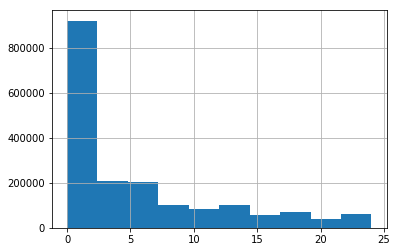

In [22]:
train.target.hist(normalize)

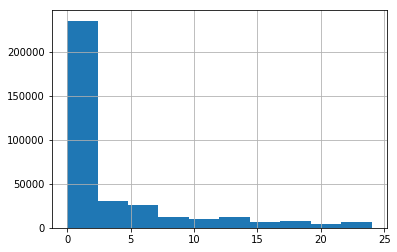

In [24]:
train[train.session_size==1].target.hist()

In [27]:
train.columns

Index(['session_id', 'step', 'session_size', 'session_duration',
       'last_duration', 'n_imps', 'target', 'prices_0', 'prices_1', 'prices_2',
       ...
       'current_filters_23', 'current_filters_24', 'current_filters_25',
       'current_filters_26', 'current_filters_27', 'current_filters_28',
       'current_filters_29', 'current_filters_30', 'current_filters_31',
       'current_filters_32'],
      dtype='object', length=190)

In [29]:
train_basic.columns

Index(['user_id', 'session_id', 'timestamp', 'step', 'action_type',
       'reference', 'platform', 'city', 'device', 'current_filters',
       'impressions', 'prices'],
      dtype='object')

In [31]:
# how many sessions there are duplciated clickout reference
train_c = train_basic[train_basic['action_type'] == 'clickout item'].reset_index(drop=True)
d = train_c.duplicated(subset=['session_id', 'reference'])

In [32]:
d.sum()

265729

In [33]:
train_c.shape

(1853016, 12)

In [34]:
265729/1853016

0.14340351081696004

In [ ]:
train_basic[train_basic.action_type=='search']

In [35]:
train_basic.action_type.unique()

array(['clickout item', 'search for item', 'filter selection',
       'interaction item image', 'change of sort order',
       'interaction item deals', 'search for destination',
       'search for poi', 'interaction item info',
       'interaction item rating'], dtype=object)

In [36]:
train_basic[train_basic.action_type=='search for poi']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
48,WDBP226XSN9E,000138ab4f789,1.541444e+09,1.0,search for poi,Fort Lauderdale - Hollywood International Airport,US,"Fort Lauderdale, USA",desktop,None,None,None
61,WDBP226XSN9E,000138ab4f789,1.541446e+09,14.0,search for poi,Port Everglades,US,"Fort Lauderdale, USA",desktop,Hotel|Motel|Resort|Focus on Distance,None,None
91,2LVZYAWP3XD7,0001acb13ccd1,1.541189e+09,8.0,search for poi,Deira City Center Mall,AA,"Dubai, United Arab Emirates",desktop,Best Value,None,None
157,38DG07L4M0KO,0001fe0007954,1.541512e+09,1.0,search for poi,Ginza Station,JP,"Tokyo, Japan",tablet,None,None,None
172,2U7433585MSR,000246890bfc6,1.541716e+09,1.0,search for poi,Wellington Waterfront,NZ,"Wellington, New Zealand",tablet,None,None,None
358,B4GJAVIIU6AM,00052d679e39b,1.541180e+09,5.0,search for poi,Camp Nou,BR,"Barcelona, Spain",desktop,Very Good Rating|Car Park|Breakfast Included|F...,None,None
465,82L82SS4MU7W,0006855fc2acc,1.541485e+09,1.0,search for poi,Roppongi Station,JP,"Tokyo, Japan",mobile,None,None,None
486,82L82SS4MU7W,0006855fc2acc,1.541486e+09,30.0,search for poi,Shinbashi Station,JP,"Tokyo, Japan",mobile,Focus on Distance,None,None
502,82L82SS4MU7W,0006855fc2acc,1.541489e+09,46.0,search for poi,Shinagawa Station,JP,"Tokyo, Japan",mobile,None,None,None
546,OD8S64CCTOJV,0006c25fcfd9e,1.541478e+09,1.0,search for poi,Sakae Station,JP,"Nagoya, Japan",mobile,None,None,None


In [40]:
train_basic.iloc[156:160]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
156,W5CEV6QV3ZYV,0001e610ce498,1.541046e+09,183.0,clickout item,488901,MX,"Guadalajara, Mexico",desktop,None,488901|43084|1515599|489071|42389|1797067|1848...,27|39|38|37|73|74|60|69|122|55|58|39|165|27|60...
157,38DG07L4M0KO,0001fe0007954,1.541512e+09,1.0,search for poi,Ginza Station,JP,"Tokyo, Japan",tablet,None,None,None
158,38DG07L4M0KO,0001fe0007954,1.541512e+09,2.0,change of sort order,interaction sort button,JP,"Tokyo, Japan",tablet,None,None,None
159,38DG07L4M0KO,0001fe0007954,1.541512e+09,3.0,change of sort order,price only,JP,"Tokyo, Japan",tablet,None,None,None


In [3]:
nrows = 1000000
train = prepare_data('train', convert_action_type=False, nrows=nrows, recompute=False)
df = compute_session_fts(train, 'train')

In [ ]:
df = df.groupby('session_id').last().reset_index()
# df['session_id_size'] = np.log(df['session_id_size'])
# df['cfs'] = df['current_filters_last_filters'].str.lower().str.split('|')

# df['prices'] = df['prices'].str.split('|')
# df['prices'] = df['prices'].apply(lambda x: [int(p) for p in x])

# df['time_steps'] = df['prices'].str.len()
# padding_mask = df['time_steps'] < 25
# df.loc[padding_mask, 'prices'] = df.loc[padding_mask, 'prices'].apply(lambda x: np.pad(x, (0, 25-len(x)),
#                                                                                        mode='constant'))
df['imps'] = df['impressions'].str.split('|')
df['imps'] = df['imps'].apply(lambda x: [int(i) for i in x])
# df.loc[padding_mask, 'impressions'] = (df.loc[padding_mask, 'impressions']
#                                          .apply(lambda x: np.pad(x, (0, 25-len(x)),mode='constant')))
df['reference'] = df['reference'].astype(int)
# filter out nan rows with reference_id not in impressions list, since if the true target in test
# is not in the impression list then it would not get evaluated
def assign_target(row):
    ref = row['reference']
    imp = list(row['imps'])
    if ref in imp:
        return imp.index(ref)
    else:
        return np.nan

df['target'] = df.apply(assign_target, axis=1)
# drop the ones whose reference is not in the impression list
df = df[df['target'].notna()].reset_index(drop=True)
df['target'] = df['target'].astype(int)
# def assign_last_ref_id(row, divide=True):
#     ref = row['reference_last_reference_id']
#     # although reference_id got converted to int, but the reference_last_reference_id was calculated
#     # when it was still str value, so here we look up the index in str of impressions
#     imp = [str(i) for i in row['imps']]

#     if pd.isna(ref):
#         return np.nan
#     else:
#         if ref in imp:
#             if divide:
#                 return (imp.index(ref) + 1) / len(imp)
#             else:
#                 return imp.index(ref) + 1
#         else:
#             return np.nan
# assign_last_ref_id_func = partial(assign_last_ref_id, divide=False)
# df['last_ref_ind'] = df.apply(assign_last_ref_id_func, axis=1)

### comapre session with size 1 and the rest

In [ ]:
df.head(2)

In [ ]:
ones = df[df['session_id_size']==1].reset_index(drop=True)
multiples = df[df['session_id_size']>1].reset_index(drop=True)

In [ ]:
oids = ones['session_id'].unique()
mids = multiples['session_id'].unique()

In [ ]:
df[df.session_id=='0000059a39020']

---
### ones

In [ ]:
display_cols = ['session_id', 'step', 'action_type', 'current_filters', 'reference', 'timestamp',
                'impressions', 'prices', 'target', 'session_id_size']
raw_display_cols = [c for c in train.columns if c in display_cols]

In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
one_rid = np.random.choice(oids, 1)[0]
print(one_rid)
df[df.session_id==one_rid][display_cols].reset_index(drop=True)

In [ ]:
# df[df.session_id==one_rid][display_cols].reset_index(drop=True).to_dict(orient='list')

In [ ]:
from colorama import Fore
dic = df[df.session_id==one_rid][display_cols].reset_index(drop=True).to_dict(orient='list')
prices = dic['prices'][0].split('|')
ref = str(dic['reference'][0])
imps = dic['impressions'][0].split('|')
# prices[imps.index(ref)] = f'{Fore.RED} {prices[imps.index(ref)]}' #{test_id}
prices[imps.index(ref)] = f'==={prices[imps.index(ref)]}===' #{test_id}
dic['prices'] = '|'.join(prices)
pp.pprint(dic)
# print(dic['prices'])

In [ ]:
print(f'{Fore.RED}{prices[imps.index(ref)]}')

In [ ]:
# # and the raw
# train[train.session_id==one_rid][raw_display_cols].reset_index(drop=True)

In [ ]:
# pp.pprint(train[train.session_id==one_rid][raw_display_cols].reset_index(drop=True).to_dict(orient='list'))

---
### Longer

In [ ]:
mid_rid = np.random.choice(mids, 1)[0]
print(mid_rid)
# df[df.session_id==mid_rid][display_cols].reset_index(drop=True)

In [ ]:
np.sort([int(i) for i in df[df.session_id==mid_rid]['prices'].str.split('|').values[0]])

In [ ]:
# pp.pprint(df[df.session_id==mid_rid][display_cols].reset_index(drop=True).to_dict(orient='list'))

In [ ]:
# the raw
train[train.session_id==mid_rid][raw_display_cols].reset_index(drop=True)

In [ ]:
pp.pprint(train[train.session_id==mid_rid][raw_display_cols].reset_index(drop=True).to_dict(orient='list'))

In [ ]:
# dup_mask = train[[c for c in train.columns if c not in ['timestamp', 'step']]].duplicated(keep=False)
# dup_mask.sum()

In [ ]:
# dup_cols = [c for c in train.columns if c not in ['timestamp', 'step']]
# # train[dup_cols].loc[train[dup_cols].shift(-1) != train[dup_cols]]
# train.groupby(dup_cols).apply(lambda x: )

In [ ]:
train.shape

In [ ]:
99508/train.shape[0]

### Look at test set
---

In [ ]:
test = load_data('tedt')

---
### Click-encodings

In [ ]:
from create_model_inputs import click_view_encoding
_ = click_view_encoding(sids=None, fold='testing', m=5)

In [ ]:
cv_enc = pd.read_csv('./cache/foldtesting_clickview_encodings.csv')

In [ ]:
cv_enc.shape

In [ ]:
cv_enc['clicked'].hist(bins=100)

---
### clickouts

In [ ]:
%%time
df = load_data('train', usecols=['session_id', 'action_type', 'impressions', 'reference'])

In [ ]:
df.shape

In [ ]:
df = df.drop_duplicates(subset=[c for c in df.columns if c != 'step']).reset_index(drop=True)

In [ ]:
df.shape

In [ ]:
%%time
# filter away sessions do not have clickout
def filter_away(df):
    return (df.action_type=='clickout item').sum() > 0
fids = df.groupby('session_id').apply(filter_away)

In [ ]:
df_has = df[df.session_id.isin(fids[fids].index)]

In [ ]:
df_has.shape

In [ ]:
# number of clickout rows
(df_has.action_type == 'clickout item').sum()

In [ ]:
last_df_has = df_has.groupby('session_id').last().reset_index()

In [ ]:
last_df_has.shape

In [ ]:
# average number of clickout per session
ctns = df_has[df_has.action_type=='clickout item'].groupby('session_id')['session_id'].size()

In [ ]:
ctns.head()

In [ ]:
s = df_has.groupby('session_id')['session_id'].size()

In [ ]:
s.head()

In [ ]:
# avg_clickout = ctns/s

In [ ]:
# avg_clickout.hist(bins=100)

In [ ]:
np.log(ctns).hist(bins=100)

In [ ]:
ctn

In [62]:
from datetime import datetime as dt
current_time = dt.now().strftime('%m-%d-%M')

In [63]:
current_time

'05-29-27'

In [2]:
sub = pd.read_csv('./subs/test_sub.csv')

In [46]:
sub = pd.read_csv('./subs/cat_sub_05-29.csv')

In [3]:
sub.head()

,session_id,impressions
0,0000059a39020,"[2251200, 924581, 4775012, 10090928, 2282660, ..."
1,000243bb22a50,"[49536, 149808, 2418418, 1122314, 149795, 5502..."
2,000356259e25a,"[948643, 34338, 18230, 100302, 1538159, 42402,..."
3,000356259e25a,"[948643, 34338, 18230, 100302, 1538159, 42402,..."
4,000356259e25a,"[948643, 34338, 18230, 100302, 1538159, 42402,..."


In [43]:
sub.shape

(486635, 3)

In [7]:
sub.loc[:, 'impressions'] = sub.loc[:, 'impressions'].apply(lambda x: literal_eval(x))


In [44]:
sub.iloc[0]

Unnamed: 0                                                     0
session_id                                         0000059a39020
impressions    [2251200, 924581, 4775012, 10090928, 2282660, ...
Name: 0, dtype: object

In [9]:
sub.iloc[0].impressions[0]

2251200

In [39]:
# from ast import literal_eval
# def convert2list(x):
# #     print('\n\n', x) 
# #     print(literal_eval(x), '\n\n')
#     try:
#         return literal_eval(x)
#     except:
#         return x.strip('([|])').split()
# test_sub.loc[:, 'impressions'] = test_sub.loc[:, 'impressions'].apply(convert2list)


In [49]:
s  = pd.read_csv('./data/submission_popular.csv')

In [5]:
s.shape

(253573, 5)

In [53]:
pd.options.display.max_colwidth=1000

In [54]:
s.head()

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 1050792 97171 353141 2094950 923407 106307 1000915 97170 147907 1838901 1729121 2182130 904851 927351 4234718 2358690 2431104 1241375 152107
1,0004Q49X39PY,9de47d9a66494,1541641157,1,3505150 3812004 2227896 2292254 3184842 2227026 8153310 10213134 320746 2213014 1978919 4504242 1012049 595506 1953665 4486372 3508724 1984229 3202894 2714500 3202412 1987127 2714480 7769010 2712428
2,0004Q49X39PY,beea5c27030cb,1541561202,1,4476010 3505150 3812004 2227896 2292254 2227026 1736323 2926933 9343000 7101352 1953665 1984229 7984902 10024490 3202894 2508850 3843244 5052004 7794970 3766088 3823768 2712428 9017272 5497362 6030666
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22854 3067559 22721 22713 16121 22772 22727 22764 150882 22716 150825 22714 22711 22798 45096 4082698 102569 5889794 102568 1478189 22819 22797 22705 22848 3498754
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,9857656 5849628 655716 1352530 502066 1405084 2176280 507861 2143854 4342348 1241177 1669587 6451832 977727 6147882 1008737 4272108 3133206 1887759 1830637 3133204 4984730 1888653 1944129 1496381


In [55]:
sub.head()

,user_id,session_id,timestamp,step,item_recommendations
0,P2L70S1Y60IF,0000059a39020,1541719950,1,2251200 924581 895299 10090928 4775012 2282660 1042070 904419 4393408 716761 9327438 494271 1725409 1574393 9814964 449646 494591 1255814 1725407 1532985 106496 1552635 1552439 394496 103453
1,SKDEGHT3I151,0000b9394297b,1541606244,2,1044228 5670638 5078576 6033244 6739860 11245146 7917004 5875672 2253886 5483610 7731204 10075218 6040960 6706660 9803684 8111266 8314306 0 7672042 0 0 0 0 0 0
2,V3SQM6X57BNX,0001650138d30,1541614783,1,44394 44247 44103 44155 44404 43972 44292 1322086 44288 843686 974755 44496 44421 44391 1253177 44904 43995 138567 43764 1285738 914037 101050 44289 44101 43959
3,13UA01X5MOHZ,000177b850519,1541574580,4,17011 17266 16122 17403 17295 17535 17040 17578 153593 1218858 4897876 16831 2232136 2612598 1977627 16842 3188920 17579 85123 17028 2881132 5050146 9117602 6001568 3140558
4,K0LALBSISIAC,00017b3b2c136,1541565393,11,6698142 6298194 7952264 5717238 2859570 2811944 3984784 5723818 7240314 4341718 9187692 401776 2810449 4277618 8175520 9672594 509856 5486494 2565452 1101646 7198288 2224450 1122702 3492498 1946813


In [56]:
sub[sub.session_id=='89643988fdbfb']

,user_id,session_id,timestamp,step,item_recommendations
136070,000324D9BBUC,89643988fdbfb,1541593942,10,1241375 923407 119494 152107 147907 101758 1729121 1050792 2182130 4234718 97171 353141 927351 1000915 2094950 106307 1033140 106315 1838901 924795 2358690 904851 903037 2431104 97170


In [57]:
to_sub = sub.groupby('session_id').last().reset_index()

In [9]:
to_sub.shape

(253573, 5)

In [10]:
to_sub.shape

(253573, 5)

In [11]:
to_sub.head()

,session_id,user_id,timestamp,step,item_recommendations
0,0000059a39020,P2L70S1Y60IF,1541719950,1,"[2251200, 924581, 4775012, 10090928, 2282660, ..."
1,0000b9394297b,SKDEGHT3I151,1541606244,2,[ 1044228 5670638 5875672 6033244 7917004 ...
2,0001650138d30,V3SQM6X57BNX,1541614783,1,"[44394, 44103, 44247, 44155, 43972, 44292, 444..."
3,000177b850519,13UA01X5MOHZ,1541574580,4,"[17011, 16122, 17403, 17040, 17266, 17295, 175..."
4,00017b3b2c136,K0LALBSISIAC,1541565393,11,"0 0 0 0 0 0 0 [5723818, 4341718, 6298194, 6698..."


In [12]:
s.head()

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 105...
1,0004Q49X39PY,9de47d9a66494,1541641157,1,3505150 3812004 2227896 2292254 3184842 222702...
2,0004Q49X39PY,beea5c27030cb,1541561202,1,4476010 3505150 3812004 2227896 2292254 222702...
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22854 3067559 22721 22713 16121 22772 22727 22...
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,9857656 5849628 655716 1352530 502066 1405084 ...


In [13]:
s[s.session_id=='0000059a39020']

,user_id,session_id,timestamp,step,item_recommendations
182944,P2L70S1Y60IF,0000059a39020,1541719950,1,1042070 106496 895299 394496 494271 716761 125...


In [15]:
to_sub.iloc[4].item_recommendations

'0 0 0 0 0 0 0 [5723818, 4341718, 6298194, 6698142, 7952264, 2859570, 5717238, 3984784, 2811944, 401776, 7240314, 509856, 9187692, 8175520, 9672594, 4277618, 5486494, 1101646, 2810449, 2224450, 1122702, 2565452, 3492498, 7198288, 1946813] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'

In [33]:
a = pd.DataFrame({'A': [[1,2,3], [0, 0, 0], [-1,-2,-3]], 
                  'B': [np.array([1,2,3]), [0, 0, 0], [-1,-2,-3]]})
a.to_csv('./dummy.csv')

In [34]:
pd.read_csv('./dummy.csv')

,Unnamed: 0,A,B
0,0,"[1, 2, 3]",[1 2 3]
1,1,"[0, 0, 0]","[0, 0, 0]"
2,2,"[-1, -2, -3]","[-1, -2, -3]"


In [4]:
train = load_data('train', nrows=10000)

[05-31 07:42:17 - utils-108 - load_data - INFO] Loading train using 10,000 rows (9,973 trimmed) which is 0.06% out of total train data


In [5]:
train.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [8]:
train[train.reference.str.contains(r'[^\d]+')]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
14,00RL8Z82B2Z1,aff3928535f48,1541038469,15,search for poi,Surry Hills,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
116,03K8AXBL4BX2,ec139e10b9238,1541100038,1,search for destination,"London, United Kingdom",UK,"London, United Kingdom",desktop,NaN,NaN,NaN
117,03K8AXBL4BX2,ec139e10b9238,1541100132,2,search for poi,Covent Garden,UK,"London, United Kingdom",desktop,NaN,NaN,NaN
118,03K8AXBL4BX2,ec139e10b9238,1541100193,3,search for poi,Oxford Street,UK,"London, United Kingdom",desktop,NaN,NaN,NaN
123,03P4VFKK12UO,325fafb5fa450,1541107285,1,search for destination,"Bakersfield, USA",US,"Bakersfield, USA",desktop,NaN,NaN,NaN
124,03P4VFKK12UO,325fafb5fa450,1541107286,2,search for destination,"Bakersfield, USA",US,"Bakersfield, USA",desktop,NaN,NaN,NaN
125,03P4VFKK12UO,325fafb5fa450,1541107336,3,filter selection,Very Good Rating,US,"Bakersfield, USA",desktop,Very Good Rating,NaN,NaN
126,03P4VFKK12UO,325fafb5fa450,1541107366,4,filter selection,Hostal (ES),US,"Bakersfield, USA",desktop,Very Good Rating|5 Star|4 Star|Hotel|Motel|Res...,NaN,NaN
127,03P4VFKK12UO,325fafb5fa450,1541107366,5,filter selection,Hotel,US,"Bakersfield, USA",desktop,Very Good Rating|5 Star|4 Star|Hotel|Motel|Res...,NaN,NaN


In [11]:
non_int

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
14,00RL8Z82B2Z1,aff3928535f48,1541038469,15,search for poi,Surry Hills,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
116,03K8AXBL4BX2,ec139e10b9238,1541100038,1,search for destination,"London, United Kingdom",UK,"London, United Kingdom",desktop,NaN,NaN,NaN
117,03K8AXBL4BX2,ec139e10b9238,1541100132,2,search for poi,Covent Garden,UK,"London, United Kingdom",desktop,NaN,NaN,NaN
118,03K8AXBL4BX2,ec139e10b9238,1541100193,3,search for poi,Oxford Street,UK,"London, United Kingdom",desktop,NaN,NaN,NaN
123,03P4VFKK12UO,325fafb5fa450,1541107285,1,search for destination,"Bakersfield, USA",US,"Bakersfield, USA",desktop,NaN,NaN,NaN
124,03P4VFKK12UO,325fafb5fa450,1541107286,2,search for destination,"Bakersfield, USA",US,"Bakersfield, USA",desktop,NaN,NaN,NaN
125,03P4VFKK12UO,325fafb5fa450,1541107336,3,filter selection,Very Good Rating,US,"Bakersfield, USA",desktop,Very Good Rating,NaN,NaN
126,03P4VFKK12UO,325fafb5fa450,1541107366,4,filter selection,Hostal (ES),US,"Bakersfield, USA",desktop,Very Good Rating|5 Star|4 Star|Hotel|Motel|Res...,NaN,NaN
127,03P4VFKK12UO,325fafb5fa450,1541107366,5,filter selection,Hotel,US,"Bakersfield, USA",desktop,Very Good Rating|5 Star|4 Star|Hotel|Motel|Res...,NaN,NaN


In [12]:
non_int = train['reference'].str.contains(r'[^\d]+')
train.loc[non_int, 'reference'] = '-1'
train['reference'] = train['reference'].astype(int)


In [15]:
from datetime import datetime as dt
dt.now().strftime('%m-%d-%H-%M')

'05-31-07-50'

In [18]:
t = pd.read_parquet('./gbm_cache/train_inputs_5000000.snappy')

In [19]:
t.head()

,session_size,session_duration,last_duration,n_imps,target,prices_0,prices_1,prices_2,prices_3,prices_4,...,current_filters_23,current_filters_24,current_filters_25,current_filters_26,current_filters_27,current_filters_28,current_filters_29,current_filters_30,current_filters_31,current_filters_32
0,3,225.0,15.0,25,0,72.0,60.0,93.0,67.0,49.0,...,0,0,0,0,0,0,0,0,0,0
1,3,50.0,17.0,21,0,125.0,159.0,174.0,51.0,50.0,...,0,0,0,0,0,0,0,0,0,0
2,3,446.0,264.0,25,0,199.0,147.0,35.0,57.0,40.0,...,0,0,0,0,0,0,0,0,0,0
3,5,513.0,65.0,25,2,199.0,147.0,35.0,57.0,40.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,0.0,25,0,607.0,242.0,147.0,232.0,127.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
numeric_cols = ['last_duration', 'n_imps', 'session_duration', 'session_size']
price_cols = [c for c in t.columns if 'price' in c]
click_cols = [c for c in t.columns if 'click' in c or 'interact' in c]
cf_cols = [c for c in t.columns if 'filter' in c]

In [27]:
set(t.columns) - set(price_cols) -set(click_cols)

{'current_filters_0',
 'current_filters_1',
 'current_filters_10',
 'current_filters_11',
 'current_filters_12',
 'current_filters_13',
 'current_filters_14',
 'current_filters_15',
 'current_filters_16',
 'current_filters_17',
 'current_filters_18',
 'current_filters_19',
 'current_filters_2',
 'current_filters_20',
 'current_filters_21',
 'current_filters_22',
 'current_filters_23',
 'current_filters_24',
 'current_filters_25',
 'current_filters_26',
 'current_filters_27',
 'current_filters_28',
 'current_filters_29',
 'current_filters_3',
 'current_filters_30',
 'current_filters_31',
 'current_filters_32',
 'current_filters_4',
 'current_filters_5',
 'current_filters_6',
 'current_filters_7',
 'current_filters_8',
 'current_filters_9',
 'last_duration',
 'n_imps',
 'session_duration',
 'session_size',
 'target'}

In [28]:
len(click_cols)

100

In [11]:
a = pd.DataFrame({'A': np.random.randint(0, 5, 10), 'B': np.random.randint(0, 5, 10)})
a

,A,B
0,3,0
1,2,4
2,1,1
3,2,2
4,0,2
5,1,1
6,1,4
7,2,3
8,1,1
9,1,0


In [17]:
def f(grp):
    if grp.A.unique()[0] >=2:
        return grp
    else:
#         return None
        return pd.DataFrame()
a.groupby('A').apply(f).reset_index(drop=True)

,A,B
0,2.0,4.0
1,2.0,2.0
2,2.0,3.0
3,3.0,0.0


In [16]:
def f(grp):
    if grp.A.unique()[0] >2:
        return grp
    else:
        return None
#         return pd.DataFrame()
a.groupby('A').apply(f)

,A,B
0,3.0,0.0
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [14]:
from preprocessing import remove_duplicates, clip_up_to_last_click
import pandas as pd
from functools import partial

In [3]:
train = pd.read_csv('./data/train.csv')

In [4]:
%%time
train = remove_duplicates(train)

[06-02 21:50:02 - preprocessing-23 - remove_duplicates - INFO] Dropping exactly same rows (except step)
[06-02 21:50:13 - preprocessing-28 - remove_duplicates - INFO] Before dropping duplicates df shape: (15,932,992, 12)
[06-02 21:50:26 - preprocessing-33 - remove_duplicates - INFO] After dropping duplicates df shape: (6,683,369, 12)


CPU times: user 20.8 s, sys: 2.86 s, total: 23.7 s
Wall time: 23.7 s


In [15]:
%%time
clip_up_to_last_click_ = partial(clip_up_to_last_click, mode='train')
train = train.groupby('session_id').apply(clip_up_to_last_click_).reset_index(drop=True)

CPU times: user 8min, sys: 3.87 s, total: 8min 4s
Wall time: 8min 3s


In [16]:
s = train.groupby('session_id').size()

In [31]:
# s.value_counts()

In [18]:
s.value_counts(normalize=True).cumsum().head(30)

1     0.246463
2     0.438518
3     0.548963
4     0.626432
5     0.688021
6     0.735001
7     0.772189
8     0.803088
9     0.827893
10    0.848804
11    0.866330
12    0.881089
13    0.893628
14    0.904312
15    0.913572
16    0.921510
17    0.928619
18    0.934533
19    0.940085
20    0.945083
21    0.949378
22    0.953210
23    0.956589
24    0.959744
25    0.962525
26    0.965011
27    0.967278
28    0.969361
29    0.971350
30    0.973087
dtype: float64

In [20]:
train['imp'] = train.impressions.str.split('|')

In [21]:
train = train[train.impressions.notna()].reset_index(drop=True)

In [24]:
%%time
import numpy as np
def find_imp_len(df):
    return len(set([j for i in df.imp for j in i]))
ss = train.groupby('session_id').apply(find_imp_len)

CPU times: user 35.7 s, sys: 0 ns, total: 35.7 s
Wall time: 35.7 s


In [25]:
ss.head()

session_id
00000510f1adc    25
00003f3b20954    25
000056cd97ce2    25
000066611146f    25
0000be39860d7    25
dtype: int64

In [37]:
ss.value_counts(normalize=True).cumsum().head(50).index.max()

75